# Correlation Analysis

In [37]:
import os
import json
import pandas as pd
import numpy as np
import scipy
from scipy.stats import wilcoxon
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format


In [38]:
RANDOM = "Random"

# tool_short_names = [RANDOM, "Triphone", "Phoneme", "PEP", "PEP-D", "SEP", "WEP", "WEP-D"]
# error_model_tool_names = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
#                           "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]
# finetuned_model_tool_names = ["random", "triphone_rich", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
#                               "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance", "word_error_real_mix/word_enhance"]

tool_short_names = [RANDOM, "Phoneme-Rich", "PEP", "PEP-D", "CrossASR", "ASRDebugger"]
error_model_tool_names = ["random", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
                          "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance"]
finetuned_model_tool_names = ["random", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
                              "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance"]

shorten_error_model_name = {}
for i in range(len(error_model_tool_names)):
    shorten_error_model_name[error_model_tool_names[i]] = tool_short_names[i]

shorten_finetuned_model_name = {}
for i in range(len(finetuned_model_tool_names)):
    shorten_finetuned_model_name[finetuned_model_tool_names[i]
                                 ] = tool_short_names[i]


def shorten_em_name(tools):
    return [shorten_error_model_name[tool] for tool in tools]


def shorten_ft_name(tools):
    return [shorten_finetuned_model_name[tool] for tool in tools]


### The relative improvement of WER after fine-tuning

In [39]:
with open('result/RQ2.json', 'r') as f:
  data = json.load(f)

asrs = ["quartznet", "hubert", "wav2vec-base"]
datasets = ["YBAA", "ZHAA", "ASI", "TNI", "NCC",
            "TXHC", "EBVS", "ERMS", "YDCK", "YKWK", "THV", "TLV"]
tools = ["random", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
         "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance"]

finetuned_model_performance_on_test_set = {}
for asr in asrs:
    finetuned_model_performance_on_test_set[asr] = {}
    for dataset in datasets:
        finetuned_model_performance_on_test_set[asr][dataset] = {}
        for tool in tools:
            finetuned_model_performance_on_test_set[asr][dataset][shorten_finetuned_model_name[tool]] = pd.read_csv(
                data[asr][dataset][tool])

finetuned_model_performance_on_test_set


{'quartznet': {'YBAA': {'Random':   Dataset  Size  WER_Seed1  WER_Seed2  WER_Seed3  WER_Avg  CER_Seed1  \
   0    YBAA   100     17.060     17.360     18.390   17.600      6.030   
   1    YBAA   200     16.240     16.240     16.650   16.380      5.810   
   2    YBAA   300     16.550     15.830     15.830   16.070      5.870   
   3    YBAA   400     16.240     15.020     17.160   16.140      5.560   
   
      CER_Seed2  CER_Seed3  CER_Avg  
   0      6.530      6.340    6.300  
   1      5.870      5.830    5.840  
   2      5.610      5.710    5.730  
   3      5.380      5.580    5.510  ,
   'Phoneme-Rich':   Dataset  Size  WER_Seed1  WER_Seed2  WER_Seed3  WER_Avg  CER_Seed1  \
   0    YBAA   100     17.360     17.670     18.280   17.770      6.160   
   1    YBAA   200     16.960     16.960     17.260   17.060      6.040   
   2    YBAA   300     16.650     16.650     16.450   16.580      5.770   
   3    YBAA   400     15.830     15.830     15.730   15.800      5.380   
   
    

In [40]:
with open('result/original.json', 'r') as f:
  original_data = json.load(f)

original_model_performance_on_test_set = {}

for asr in asrs:
    original_model_performance_on_test_set[asr] = {}
    for dataset in datasets:
        original_model_performance_on_test_set[asr][dataset] = original_data[asr][dataset]["test"]["wer"]

# original_model_performance_on_test_set



In [41]:
relative_improvement_of_finetuned_model = {}
for asr in asrs:
    relative_improvement_of_finetuned_model[asr] = {}
    for dataset in datasets:
        relative_improvement_of_finetuned_model[asr][dataset] = {}
        for tool in shorten_ft_name(tools):
            relative_improvement_of_finetuned_model[asr][dataset][tool] = {}
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3", "WER_Avg"]:
                relative_improvement_of_finetuned_model[asr][dataset][tool][metric] = np.dot(100, (
                    (original_model_performance_on_test_set[asr][dataset] - finetuned_model_performance_on_test_set[asr][dataset][tool][metric]) / original_model_performance_on_test_set[asr][dataset]).to_list())

relative_improvement_of_finetuned_model


{'quartznet': {'YBAA': {'Random': {'WER_Seed1': array([18.13819578, 22.07293666, 20.58541267, 22.07293666]),
    'WER_Seed2': array([16.69865643, 22.07293666, 24.0403071 , 27.92706334]),
    'WER_Seed3': array([11.756238  , 20.10556622, 24.0403071 , 17.65834933]),
    'WER_Avg': array([15.54702495, 21.40115163, 22.88867562, 22.55278311])},
   'Phoneme-Rich': {'WER_Seed1': array([16.69865643, 18.61804223, 20.10556622, 24.0403071 ]),
    'WER_Seed2': array([15.21113244, 18.61804223, 20.10556622, 24.0403071 ]),
    'WER_Seed3': array([12.2840691 , 17.17850288, 21.06525912, 24.52015355]),
    'WER_Avg': array([14.73128599, 18.13819578, 20.44145873, 24.18426104])},
   'PEP': {'WER_Seed1': array([10.79654511, 22.55278311, 24.0403071 , 25.47984645]),
    'WER_Seed2': array([18.13819578, 19.14587332, 19.62571977, 23.03262956]),
    'WER_Seed3': array([17.65834933, 18.61804223, 23.56046065, 25.        ]),
    'WER_Avg': array([15.54702495, 20.10556622, 22.40882917, 24.52015355])},
   'PEP-D': {

In [42]:
for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
    print("ASR: ", "wav2vec-base")
    print("Metric: ", metric)
    print("ASRDebugger: \t", relative_improvement_of_finetuned_model["wav2vec-base"]["THV"]["ASRDebugger"][metric])
    print("Phoneme-Rich: \t", relative_improvement_of_finetuned_model["wav2vec-base"]["THV"]["Phoneme-Rich"][metric])
    print()


ASR:  wav2vec-base
Metric:  WER_Seed1
ASRDebugger: 	 [13.57466063 19.18049271 21.24183007 21.49321267]
Phoneme-Rich: 	 [15.86224233 18.4263449  20.21116139 24.05731523]

ASR:  wav2vec-base
Metric:  WER_Seed2
ASRDebugger: 	 [14.07742584 17.64705882 17.89844143 23.78079437]
Phoneme-Rich: 	 [13.82604324 17.89844143 21.74459527 22.24736048]

ASR:  wav2vec-base
Metric:  WER_Seed3
ASRDebugger: 	 [15.86224233 16.64152841 21.24183007 22.77526395]
Phoneme-Rich: 	 [13.82604324 17.89844143 20.46254399 19.70839618]



## Create Table 4

In [43]:
relative_improvement_of_finetuned_model_averaged_by_seed_and_budget = {}
for asr in asrs:
    relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr] = {}
    for dataset in datasets:
        relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset] = {}
        for tool in shorten_ft_name(tools):
            relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset][tool] = round(np.mean(relative_improvement_of_finetuned_model[asr][dataset][tool]["WER_Avg"]),2)

relative_improvement_of_finetuned_model_averaged_by_seed_and_budget


{'quartznet': {'YBAA': {'Random': 20.6,
   'Phoneme-Rich': 19.37,
   'PEP': 20.65,
   'PEP-D': 20.38,
   'CrossASR': 20.15,
   'ASRDebugger': 20.77},
  'ZHAA': {'Random': 17.51,
   'Phoneme-Rich': 17.54,
   'PEP': 18.58,
   'PEP-D': 13.93,
   'CrossASR': 19.11,
   'ASRDebugger': 16.42},
  'ASI': {'Random': 14.47,
   'Phoneme-Rich': 10.24,
   'PEP': 15.96,
   'PEP-D': 16.01,
   'CrossASR': 15.64,
   'ASRDebugger': 15.85},
  'TNI': {'Random': 13.13,
   'Phoneme-Rich': 12.1,
   'PEP': 9.93,
   'PEP-D': 11.8,
   'CrossASR': 11.78,
   'ASRDebugger': 12.98},
  'NCC': {'Random': 21.05,
   'Phoneme-Rich': 21.38,
   'PEP': 21.94,
   'PEP-D': 21.62,
   'CrossASR': 20.91,
   'ASRDebugger': 21.09},
  'TXHC': {'Random': 28.77,
   'Phoneme-Rich': 26.91,
   'PEP': 28.65,
   'PEP-D': 28.43,
   'CrossASR': 28.06,
   'ASRDebugger': 29.55},
  'EBVS': {'Random': 11.58,
   'Phoneme-Rich': 10.86,
   'PEP': 10.57,
   'PEP-D': 11.53,
   'CrossASR': 12.2,
   'ASRDebugger': 11.5},
  'ERMS': {'Random': 18.96,
  

In [45]:
print(relative_improvement_of_finetuned_model_averaged_by_seed_and_budget["wav2vec-base"]["THV"]["Phoneme-Rich"])
print(relative_improvement_of_finetuned_model_averaged_by_seed_and_budget["wav2vec-base"]["THV"]["ASRDebugger"])



18.85
18.78


In [9]:
relative_improvement_of_finetuned_model_averaged_by_seed_and_budget

for asr in asrs :
    for dataset in datasets:
        dic = relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset]
        best_method = max(dic, key=dic.get)
        worst_method = min(dic, key=dic.get)
        relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset][
            best_method] = "\setGoodColor{}" + f"{relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset][best_method]:.2f}"
        
        relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset][
            worst_method] = "\setBadColor{}" + f"{relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr][dataset][worst_method]:.2f}"

        # print(asr, dataset, best_method)
        # print(asr, dataset, worst_method)
        


In [11]:
pd.options.display.float_format = "{:,.2f}".format

df = {}
for asr in asrs :
    df[asr] = pd.DataFrame(relative_improvement_of_finetuned_model_averaged_by_seed_and_budget[asr]).T

df["wav2vec-base"]


,Random,Phoneme-Rich,PEP,PEP-D,CrossASR,ASRDebugger
YBAA,13.03,\setBadColor{}8.50,10.72,\setGoodColor{}13.08,11.47,11.05
ZHAA,14.51,\setBadColor{}13.73,\setGoodColor{}15.64,14.69,14.90,13.89
ASI,18.52,17.36,\setBadColor{}16.62,17.63,18.95,\setGoodColor{}19.84
TNI,30.04,29.65,29.61,\setBadColor{}29.24,31.41,\setGoodColor{}31.67
NCC,\setGoodColor{}22.20,22.14,20.81,20.92,\setBadColor{}20.48,21.14
TXHC,\setGoodColor{}24.68,\setBadColor{}21.55,22.13,23.48,24.68,22.37
EBVS,\setGoodColor{}15.05,\setBadColor{}14.00,14.14,14.39,14.42,14.54
ERMS,26.83,27.06,\setBadColor{}26.60,26.74,\setGoodColor{}28.78,28.02
YDCK,25.31,24.19,25.72,\setBadColor{}24.09,\setGoodColor{}26.89,26.34
YKWK,13.07,13.15,11.59,\setBadColor{}11.07,\setGoodColor{}13.49,13.04


In [43]:
def print_table(df):
    print(df.to_latex(escape=False))

for asr in asrs :
    print_table(df[asr])

\begin{tabular}{lllllll}
\toprule
{} &                Random &          Phoneme-Rich &                   PEP &                 PEP-D &              CrossASR &           ASRDebugger \\
\midrule
YBAA &                 20.60 &   \setBadColor{}19.37 &                 20.65 &                 20.38 &                 20.15 &  \setGoodColor{}20.77 \\
ZHAA &                 17.51 &                 17.54 &                 18.58 &   \setBadColor{}13.93 &  \setGoodColor{}19.11 &                 16.42 \\
ASI  &                 14.47 &   \setBadColor{}10.24 &                 15.96 &  \setGoodColor{}16.01 &                 15.64 &                 15.85 \\
TNI  &  \setGoodColor{}13.13 &                 12.10 &    \setBadColor{}9.93 &                 11.80 &                 11.78 &                 12.98 \\
NCC  &                 21.05 &                 21.38 &  \setGoodColor{}21.94 &                 21.62 &   \setBadColor{}20.91 &                 21.09 \\
TXHC &                 28.77 &   \setBadColor{}

#### Comparing the performance of WEP (where it's the best performing one) with the performance of second best model excluding WEP-D and PEP-D

In [12]:
finetuned_model_performance_averaged_by_seed_and_budget = {}

for asr in asrs:
    finetuned_model_performance_averaged_by_seed_and_budget[asr] = {}
    for dataset in datasets:
        temp = {}
        for tool in tool_short_names:
            temp[tool] = np.mean(
                finetuned_model_performance_on_test_set[asr][dataset][tool]["WER_Avg"])
        temp = dict(sorted(temp.items(), key=lambda item: item[1]))
        finetuned_model_performance_averaged_by_seed_and_budget[asr][dataset] = temp

finetuned_model_performance_averaged_by_seed_and_budget

{'quartznet': {'YBAA': {'ASRDebugger': 16.512500000000003,
   'PEP': 16.5375,
   'Random': 16.5475,
   'PEP-D': 16.5925,
   'CrossASR': 16.64,
   'Phoneme-Rich': 16.8025},
  'ZHAA': {'CrossASR': 16.785,
   'PEP': 16.895,
   'Phoneme-Rich': 17.11,
   'Random': 17.1175,
   'ASRDebugger': 17.3425,
   'PEP-D': 17.86},
  'ASI': {'PEP-D': 12.9175,
   'PEP': 12.924999999999999,
   'ASRDebugger': 12.942499999999999,
   'CrossASR': 12.975,
   'Random': 13.155,
   'Phoneme-Rich': 13.805},
  'TNI': {'Random': 15.879999999999999,
   'ASRDebugger': 15.907499999999999,
   'Phoneme-Rich': 16.067500000000003,
   'PEP-D': 16.122500000000002,
   'CrossASR': 16.127499999999998,
   'PEP': 16.465},
  'NCC': {'PEP': 23.690000000000005,
   'PEP-D': 23.7875,
   'Phoneme-Rich': 23.8625,
   'ASRDebugger': 23.950000000000003,
   'Random': 23.96,
   'CrossASR': 24.0025},
  'TXHC': {'ASRDebugger': 16.055,
   'Random': 16.2325,
   'PEP': 16.259999999999998,
   'PEP-D': 16.31,
   'CrossASR': 16.395,
   'Phoneme-Rich

In [90]:
WEP_relative_improvement_with_second_best_method = []
for asr in asrs:
    for dataset in datasets :
        curr_data = finetuned_model_performance_averaged_by_seed_and_budget[asr][dataset]
        key = list(curr_data.keys())
        best_method = key[0]
        if best_method == "WEP":
            for i in range(1, len(key)):
                if key[i] not in ["WEP-D", "PEP-D"]:
                    WEP_relative_improvement_with_second_best_method \
                        .append(100 * (curr_data[key[i]] - curr_data[best_method])/curr_data[key[i]])
                    break

np.mean(WEP_relative_improvement_with_second_best_method)


1.0152988776522551

### 1. Correlation between the original model's WER on the selected samples and the relative improvement of WER after fine-tuning

In [8]:
def save_to_file(fpath, printed, significant_count, non_significant_count):
    """Save the correlation analysis into external file."""
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    with open(fpath, 'w') as f:
        f.write(f"Significant: \t\t{significant_count}\n")
        f.write(f"Non-significant: \t{non_significant_count}\n")
        f.write(
            f"Total: \t\t\t\t{significant_count + non_significant_count}\n")
        f.write(
            f"Percentage: \t\t{100*significant_count / (significant_count + non_significant_count):.2f}%\n\n")
        for line in printed:
            f.write(line)
            f.write('\n')


CONFIDENCE_LEVEL = 0.05


In [7]:
with open('result/RQ1.json', 'r') as f:
  rq1_data = json.load(f)


original_model_performance_on_selected_samples = {}

asrs = ["quartznet", "hubert", "wav2vec-base"]
datasets = ["YBAA", "ZHAA", "ASI", "TNI", "NCC",
            "TXHC", "EBVS", "ERMS", "YDCK", "YKWK", "THV", "TLV"]
tools = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
         "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]

original_model_performance_on_selected_samples = {}
for asr in asrs:
    original_model_performance_on_selected_samples[asr] = {}
    for dataset in datasets:
        original_model_performance_on_selected_samples[asr][dataset] = {}
        for tool in tools:
            original_model_performance_on_selected_samples[asr][dataset][shorten_error_model_name[tool]] = {}
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3", "WER_Avg"]:
                original_model_performance_on_selected_samples[asr][dataset][shorten_error_model_name[tool]][metric] = pd.read_csv(
                  rq1_data[asr][dataset][tool])[metric].tolist()

# original_model_performance_on_selected_samples


In [8]:
## without any grouping mechanism

printed = []
significant_count = 0
non_significant_count = 0


arr_1 = []
arr_2 = []
for dataset in datasets:
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_1 += original_model_performance_on_selected_samples[asr][dataset][tool_short_name][metric]
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

assert len(arr_1) == len(arr_2)
correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)


printed.append(f"Corr coef:\t{correlation_coefficient}")
printed.append(f"p-value:\t{p_value}")
if p_value < CONFIDENCE_LEVEL:
    printed.append(f"SIGNIFICANT")
    significant_count += 1

else:
    non_significant_count += 1
    printed.append(f"NO")


fpath = "result/analyze/1/original_model_performance_correlation_without_any_grouping.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [9]:
## group by dataset

printed = []
significant_count = 0
non_significant_count = 0

for dataset in datasets:
    arr_1 = []
    arr_2 = []
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_1 += original_model_performance_on_selected_samples[asr][dataset][tool_short_name][metric]
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

    assert len(arr_1) == len(arr_2)
    correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

    printed.append(f"Dataset: {dataset}")
    printed.append(f"Corr coef:\t{correlation_coefficient}")
    printed.append(f"p-value:\t{p_value}")
    if p_value < CONFIDENCE_LEVEL:
        printed.append(f"SIGNIFICANT")
        significant_count += 1
    else:
        printed.append(f"NO")
        non_significant_count += 1
    printed.append("")


fpath = "result/analyze/1/original_model_performance_correlation_group_by_dataset.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [10]:
## group by dataset and ASR

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                arr_1 += original_model_performance_on_selected_samples[asr][dataset][tool_short_name][metric]
                arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/1/original_model_performance_correlation_group_by_dataset_and_asr.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [11]:
## group by dataset and ASR then averaging budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                curr_arr_1 = original_model_performance_on_selected_samples[asr][dataset][tool_short_name][metric]
                arr_1.append(np.mean(curr_arr_1))
                curr_arr_2 = relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]
                arr_2.append(np.mean(curr_arr_2))


        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/1/original_model_performance_correlation_group_by_dataset_and_asr_then_averaging_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [12]:
## group by dataset and ASR and budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        
        temp_1 = {}
        temp_2 = {}
        
        for tool_short_name in tool_short_names:
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                for budget, val in zip([100, 200, 300, 400], original_model_performance_on_selected_samples[asr][dataset][tool_short_name][metric]):
                    if budget not in temp_1:
                        temp_1[budget] = []
                    temp_1[budget].append(val)

                
                for budget, val in zip([100, 200, 300, 400], relative_improvement_of_finetuned_model[
                    asr][dataset][tool_short_name][metric]) :
                    if budget not in temp_2:
                        temp_2[budget] = []
                    temp_2[budget].append(val)
        

        for budget in [100, 200, 300, 400]:
            arr_1 = temp_1[budget]
            arr_2 = temp_2[budget]

            assert len(arr_1) == len(arr_2)
            correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

            printed.append(f"Dataset: {dataset}")
            printed.append(f"ASR: {asr}")
            printed.append(f"Budget: {budget}")
            printed.append(f"Corr coef:\t{correlation_coefficient}")
            printed.append(f"p-value:\t{p_value}")
            if p_value < CONFIDENCE_LEVEL:
                printed.append(f"SIGNIFICANT")
                significant_count += 1

            else:
                printed.append(f"NO")
                non_significant_count += 1
            printed.append("")


fpath = "result/analyze/1/original_model_performance_correlation_group_by_dataset_and_asr_and_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


### 3. Correlation between "the distance of triphone rich distribution and ideal distribution on the selected samples" and the relative improvement of WER after fine-tuning

In [13]:
with open('result/triphone_rich.json', 'r') as f:
  triphone_rich = json.load(f)

tools = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
         "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]


In [14]:
## without any grouping mechanism

printed = []
significant_count = 0
non_significant_count = 0


arr_1 = []
arr_2 = []
for dataset in datasets:
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += triphone_rich[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

assert len(arr_1) == len(arr_2)
correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)


printed.append(f"Corr coef:\t{correlation_coefficient}")
printed.append(f"p-value:\t{p_value}")
if p_value < CONFIDENCE_LEVEL:
    printed.append(f"SIGNIFICANT")
    significant_count += 1

else:
    non_significant_count += 1
    printed.append(f"NO")


fpath = "result/analyze/3/triphone_rich_correlation_without_any_grouping.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [15]:
## group by dataset

printed = []
significant_count = 0
non_significant_count = 0

for dataset in datasets:
    arr_1 = []
    arr_2 = []
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += triphone_rich[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

    assert len(arr_1) == len(arr_2)
    correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

    printed.append(f"Dataset: {dataset}")
    printed.append(f"Corr coef:\t{correlation_coefficient}")
    printed.append(f"p-value:\t{p_value}")
    if p_value < CONFIDENCE_LEVEL:
        printed.append(f"SIGNIFICANT")
        significant_count += 1
    else:
        printed.append(f"NO")
        non_significant_count += 1
    printed.append("")


fpath = "result/analyze/3/triphone_rich_correlation_group_by_dataset.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [16]:
## group by dataset and ASR

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += triphone_rich[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/3/triphone_rich_correlation_group_by_dataset_and_asr.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [17]:
## group by dataset and ASR then averaging budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                curr_arr_1 = triphone_rich[asr][dataset][tool][seed]
                arr_1.append(np.mean(curr_arr_1))
            
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                curr_arr_2 = relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]
                arr_2.append(np.mean(curr_arr_2))


        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/3/triphone_rich_correlation_group_by_dataset_and_asr_then_averaging_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [18]:
## group by dataset and ASR and budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        
        temp_1 = {}
        temp_2 = {}
        
        
        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                for budget, val in zip([100, 200, 300, 400], triphone_rich[asr][dataset][tool][seed]) :
                    if budget not in temp_1:
                        temp_1[budget] = []
                    temp_1[budget].append(val)
                

            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                for budget, val in zip([100, 200, 300, 400], relative_improvement_of_finetuned_model[
                    asr][dataset][tool_short_name][metric]) :
                    if budget not in temp_2:
                        temp_2[budget] = []
                    temp_2[budget].append(val)
        

        for budget in [100, 200, 300, 400]:
            arr_1 = temp_1[budget]
            arr_2 = temp_2[budget]

            assert len(arr_1) == len(arr_2)
            correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

            printed.append(f"Dataset: {dataset}")
            printed.append(f"ASR: {asr}")
            printed.append(f"Budget: {budget}")
            printed.append(f"Corr coef:\t{correlation_coefficient}")
            printed.append(f"p-value:\t{p_value}")
            if p_value < CONFIDENCE_LEVEL:
                printed.append(f"SIGNIFICANT")
                significant_count += 1

            else:
                printed.append(f"NO")
                non_significant_count += 1
            printed.append("")


fpath = "result/analyze/3/triphone_rich_correlation_group_by_dataset_and_asr_and_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


### 4. Correlation between the phoneme submodular function on the selected samples and the relative improvement of WER after fine-tuning

In [19]:
with open('result/phoneme_submodular_function.json', 'r') as f:
  phoneme_submodular_function = json.load(f)

tools = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
         "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]


In [20]:
## without any grouping mechanism

printed = []
significant_count = 0
non_significant_count = 0


arr_1 = []
arr_2 = []
for dataset in datasets:
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += phoneme_submodular_function[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

assert len(arr_1) == len(arr_2)
correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)


printed.append(f"Corr coef:\t{correlation_coefficient}")
printed.append(f"p-value:\t{p_value}")
if p_value < CONFIDENCE_LEVEL:
    printed.append(f"SIGNIFICANT")
    significant_count += 1

else:
    non_significant_count += 1
    printed.append(f"NO")


fpath = "result/analyze/4/phoneme_submodular_function_correlation_without_any_grouping.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [21]:
## group by dataset

printed = []
significant_count = 0
non_significant_count = 0

for dataset in datasets:
    arr_1 = []
    arr_2 = []
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += phoneme_submodular_function[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

    assert len(arr_1) == len(arr_2)
    correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

    printed.append(f"Dataset: {dataset}")
    printed.append(f"Corr coef:\t{correlation_coefficient}")
    printed.append(f"p-value:\t{p_value}")
    if p_value < CONFIDENCE_LEVEL:
        printed.append(f"SIGNIFICANT")
        significant_count += 1
    else:
        printed.append(f"NO")
        non_significant_count += 1
    printed.append("")


fpath = "result/analyze/4/phoneme_submodular_function_correlation_group_by_dataset.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [22]:
## group by dataset and ASR

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += phoneme_submodular_function[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/4/phoneme_submodular_function_correlation_group_by_dataset_and_asr.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [23]:
## group by dataset and ASR then averaging budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                curr_arr_1 = phoneme_submodular_function[asr][dataset][tool][seed]
                arr_1.append(np.mean(curr_arr_1))
            
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                curr_arr_2 = relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]
                arr_2.append(np.mean(curr_arr_2))


        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/4/phoneme_submodular_function_correlation_group_by_dataset_and_asr_then_averaging_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [24]:
## group by dataset and ASR and budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        
        temp_1 = {}
        temp_2 = {}
        
        
        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                for budget, val in zip([100, 200, 300, 400], phoneme_submodular_function[asr][dataset][tool][seed]) :
                    if budget not in temp_1:
                        temp_1[budget] = []
                    temp_1[budget].append(val)
                

            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                for budget, val in zip([100, 200, 300, 400], relative_improvement_of_finetuned_model[
                    asr][dataset][tool_short_name][metric]) :
                    if budget not in temp_2:
                        temp_2[budget] = []
                    temp_2[budget].append(val)
        

        for budget in [100, 200, 300, 400]:
            arr_1 = temp_1[budget]
            arr_2 = temp_2[budget]

            assert len(arr_1) == len(arr_2)
            correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

            printed.append(f"Dataset: {dataset}")
            printed.append(f"ASR: {asr}")
            printed.append(f"Budget: {budget}")
            printed.append(f"Corr coef:\t{correlation_coefficient}")
            printed.append(f"p-value:\t{p_value}")
            if p_value < CONFIDENCE_LEVEL:
                printed.append(f"SIGNIFICANT")
                significant_count += 1

            else:
                printed.append(f"NO")
                non_significant_count += 1
            printed.append("")


fpath = "result/analyze/4/phoneme_submodular_function_correlation_group_by_dataset_and_asr_and_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


### 5. Correlation between the number of test cases on the selected samples and the relative improvement of WER after fine-tuning

In [25]:
with open('result/number_of_test_cases.json', 'r') as f:
  number_of_test_cases = json.load(f)

tools = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
         "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]


In [26]:
## without any grouping mechanism

printed = []
significant_count = 0
non_significant_count = 0


arr_1 = []
arr_2 = []
for dataset in datasets:
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += number_of_test_cases[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

assert len(arr_1) == len(arr_2)
correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)


printed.append(f"Corr coef:\t{correlation_coefficient}")
printed.append(f"p-value:\t{p_value}")
if p_value < CONFIDENCE_LEVEL:
    printed.append(f"SIGNIFICANT")
    significant_count += 1

else:
    non_significant_count += 1
    printed.append(f"NO")


fpath = "result/analyze/5/number_of_test_cases_correlation_without_any_grouping.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [27]:
## group by dataset

printed = []
significant_count = 0
non_significant_count = 0

for dataset in datasets:
    arr_1 = []
    arr_2 = []
    for asr in asrs:
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += number_of_test_cases[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

    assert len(arr_1) == len(arr_2)
    correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

    printed.append(f"Dataset: {dataset}")
    printed.append(f"Corr coef:\t{correlation_coefficient}")
    printed.append(f"p-value:\t{p_value}")
    if p_value < CONFIDENCE_LEVEL:
        printed.append(f"SIGNIFICANT")
        significant_count += 1
    else:
        printed.append(f"NO")
        non_significant_count += 1
    printed.append("")


fpath = "result/analyze/5/number_of_test_cases_correlation_group_by_dataset.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [28]:
## group by dataset and ASR

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
          for seed in ["1", "2", "3"]:
              arr_1 += number_of_test_cases[asr][dataset][tool][seed]
          for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
              arr_2 += relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]

        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/5/number_of_test_cases_correlation_group_by_dataset_and_asr.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [29]:
## group by dataset and ASR then averaging budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:
        arr_1 = []
        arr_2 = []
        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                curr_arr_1 = number_of_test_cases[asr][dataset][tool][seed]
                arr_1.append(np.mean(curr_arr_1))
            
            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                curr_arr_2 = relative_improvement_of_finetuned_model[asr][dataset][tool_short_name][metric]
                arr_2.append(np.mean(curr_arr_2))


        assert len(arr_1) == len(arr_2)
        correlation_coefficient, p_value = scipy.stats.spearmanr(arr_1, arr_2)

        printed.append(f"Dataset: {dataset}")
        printed.append(f"ASR: {asr}")
        printed.append(f"Corr coef:\t{correlation_coefficient}")
        printed.append(f"p-value:\t{p_value}")
        if p_value < CONFIDENCE_LEVEL:
            printed.append(f"SIGNIFICANT")
            significant_count += 1

        else:
            printed.append(f"NO")
            non_significant_count += 1
        printed.append("")


fpath = "result/analyze/5/number_of_test_cases_correlation_group_by_dataset_and_asr_then_averaging_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


In [30]:
## group by dataset and ASR and budget

printed = []
significant_count = 0
non_significant_count = 0


for dataset in datasets:
    for asr in asrs:

        temp_1 = {}
        temp_2 = {}

        for tool_short_name, tool in zip(tool_short_names, tools):
            for seed in ["1", "2", "3"]:
                for budget, val in zip([100, 200, 300, 400], number_of_test_cases[asr][dataset][tool][seed]):
                    if budget not in temp_1:
                        temp_1[budget] = []
                    temp_1[budget].append(val)

            for metric in ["WER_Seed1", "WER_Seed2", "WER_Seed3"]:
                for budget, val in zip([100, 200, 300, 400], relative_improvement_of_finetuned_model[
                        asr][dataset][tool_short_name][metric]):
                    if budget not in temp_2:
                        temp_2[budget] = []
                    temp_2[budget].append(val)

        for budget in [100, 200, 300, 400]:
            arr_1 = temp_1[budget]
            arr_2 = temp_2[budget]

            assert len(arr_1) == len(arr_2)
            correlation_coefficient, p_value = scipy.stats.spearmanr(
                arr_1, arr_2)

            printed.append(f"Dataset: {dataset}")
            printed.append(f"ASR: {asr}")
            printed.append(f"Budget: {budget}")
            printed.append(f"Corr coef:\t{correlation_coefficient}")
            printed.append(f"p-value:\t{p_value}")
            if p_value < CONFIDENCE_LEVEL:
                printed.append(f"SIGNIFICANT")
                significant_count += 1

            else:
                printed.append(f"NO")
                non_significant_count += 1
            printed.append("")


fpath = "result/analyze/5/number_of_test_cases_correlation_group_by_dataset_and_asr_and_budget.txt"
save_to_file(fpath, printed, significant_count, non_significant_count)


## Correlation Analysis between the 4 Features

In [37]:
# original_model_performance_on_selected_samples
# triphone_rich
# phoneme_submodular_function
# number_of_test_cases

In [34]:
# standardize the index of the dictionary

original_model_performance_standardized = {}
for asr in asrs :
    original_model_performance_standardized[asr] = {}
    for dataset in datasets :
        original_model_performance_standardized[asr][dataset] = {}
        for tool, tool_short_name in zip(finetuned_model_tool_names, tool_short_names):
            original_model_performance_standardized[asr][dataset][tool_short_name] = {}
            for seed in ["1", "2", "3"]:
                original_model_performance_standardized[asr][dataset][tool_short_name][seed] = original_model_performance_on_selected_samples[
                    asr][dataset][tool_short_name][f"WER_Seed{seed}"]

# original_model_performance_standardized


In [38]:
# standardize the index of the dictionary

triphone_rich_standardized = {}
for asr in asrs:
    triphone_rich_standardized[asr] = {}
    for dataset in datasets:
        triphone_rich_standardized[asr][dataset] = {}
        for tool, tool_short_name in zip(error_model_tool_names, tool_short_names):
            triphone_rich_standardized[asr][dataset][tool_short_name] = {}
            for seed in ["1", "2", "3"]:
                triphone_rich_standardized[asr][dataset][tool_short_name][seed] = triphone_rich[asr][dataset][tool][seed]

# triphone_rich_standardized


In [39]:
# standardize the index of the dictionary

phoneme_submodular_function_standardized = {}
for asr in asrs:
    phoneme_submodular_function_standardized[asr] = {}
    for dataset in datasets:
        phoneme_submodular_function_standardized[asr][dataset] = {}
        for tool, tool_short_name in zip(error_model_tool_names, tool_short_names):
            phoneme_submodular_function_standardized[asr][dataset][tool_short_name] = {}
            for seed in ["1", "2", "3"]:
                phoneme_submodular_function_standardized[asr][dataset][tool_short_name][seed] = phoneme_submodular_function[asr][dataset][tool][seed]

# phoneme_submodular_function_standardized


In [40]:
# standardize the index of the dictionary

number_of_test_cases_standardized = {}
for asr in asrs:
    number_of_test_cases_standardized[asr] = {}
    for dataset in datasets:
        number_of_test_cases_standardized[asr][dataset] = {}
        for tool, tool_short_name in zip(error_model_tool_names, tool_short_names):
            number_of_test_cases_standardized[asr][dataset][tool_short_name] = {}
            for seed in ["1", "2", "3"]:
                number_of_test_cases_standardized[asr][dataset][tool_short_name][seed] = number_of_test_cases[asr][dataset][tool][seed]

# number_of_test_cases_standardized


In [55]:
raw_data = {
    "original_model_performance": original_model_performance_standardized,
    "triphone_rich": triphone_rich_standardized,
    "phoneme_submodular_function": phoneme_submodular_function_standardized,
    "number_of_test_cases": number_of_test_cases_standardized,
}

data = {
    "OMP": [],
    "TR": [],
    "PSF": [],
    "NTC": [],
}


In [56]:
## without any grouping mechanism

for feature, feature_short_name in zip(raw_data.keys(), data.keys()):
    for dataset in datasets:
        for asr in asrs:
            for tool in tool_short_names:
                for seed in ["1", "2", "3"]:
                    data[feature_short_name] += list(
                        raw_data[feature][asr][dataset][tool][seed])

    


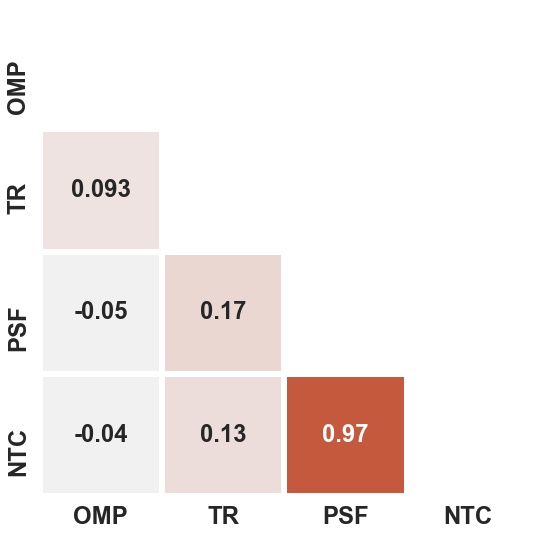

In [77]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# https://stackoverflow.com/questions/33104322/auto-adjust-font-size-in-seaborn-heatmap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")


df = pd.DataFrame(data)

corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0,
#             square=True, linewidths=5.5, cbar_kws={"shrink": 0.75},
#             annot=True, annot_kws={"fontsize": 24, "fontweight": "bold"})

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0,
            square=True, linewidths=5.5, cbar=False,
            annot=True, annot_kws={"fontsize": 24, "fontweight": "bold"})


plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')


plt.show()


In [79]:
# Check significance of the correlation

computed = set()

for feature_short_name_1 in data.keys():
    for feature_short_name_2 in data.keys():
        if feature_short_name_1 != feature_short_name_2:
            key = min(f"{feature_short_name_1}-{feature_short_name_2}", f"{feature_short_name_2}-{feature_short_name_1}")
            if key not in computed:
                print(feature_short_name_1, feature_short_name_2)
                print(scipy.stats.spearmanr(data[feature_short_name_1], data[feature_short_name_2]))
                print()
                computed.add(key)


OMP TR
SpearmanrResult(correlation=0.0933260050061298, pvalue=3.8753382196932764e-08)

OMP PSF
SpearmanrResult(correlation=-0.049776908145994885, pvalue=0.0034221751571080184)

OMP NTC
SpearmanrResult(correlation=-0.03984965006167292, pvalue=0.01914197492722484)

TR PSF
SpearmanrResult(correlation=0.165284124710173, pvalue=1.365245721993725e-22)

TR NTC
SpearmanrResult(correlation=0.12982507375871097, pvalue=1.833327615028422e-14)

PSF NTC
SpearmanrResult(correlation=0.9744634677070965, pvalue=0.0)

